## Overview: Linear Mixed Model Analyses for 15 Subcortical Volume Measures
### Preparation
1. Install packages and load libraries
1. Set working directory and import data
1. Replace 999/777 in income and education. Create puberty status variable. 
1. Specify data type (numeric or factor (nominal/ordinal))
1. Copy smri variables and change colnames before winsorization 
1. Standardize smri_vol variables
1. Winsorize smri vol variables (df4 final dataframe for LMM)

### Linear Mixed Models - subcortical volumes
1. LMMs: loop over dependent variables
1. Create tables with p-values (uncorrected and corrected), t-values, cohen's d
1. Transform tables created in step 2 from wide to long format for heatmaps
1. Plot heatmaps
1. Plot effects, random effects and examine whether assumptions are met
1. Interpretation

### Preparation

#### 1. Install packages and load libraries

In [ ]:
#install packages 
if (!('lme4'     %in% installed.packages()[,"Package"])) install.packages('lme4')
if (!('EMAtools' %in% installed.packages()[,"Package"])) install.packages('EMAtools')  #lme.dscore
if (!('naniar'   %in% installed.packages()[,"Package"])) install.packages('naniar')    #replace values 
if (!('jtools'   %in% installed.packages()[,"Package"])) install.packages('jtools')
if (!('ggplot2'  %in% installed.packages()[,"Package"])) install.packages('ggplot2')
if (!('sjPlot'   %in% installed.packages()[,"Package"])) install.packages('sjPlot')
if (!('effects'  %in% installed.packages()[,"Package"])) install.packages('effects')
if (!('lmerTest' %in% installed.packages()[,"Package"])) install.packages('lmerTest')
if (!('tidyverse'   %in% installed.packages()[,"Package"])) install.packages('tidyverse') #organize data in long format (for heatmaps)
if (!('glmmTMB'   %in% installed.packages()[,"Package"])) install.packages('glmmTMB') #plot effects
if (!('viridis'   %in% installed.packages()[,"Package"])) install.packages('viridis') #colormap heatmaps

# load libraries
if(!"lme4" %in% .packages())     library(lme4)
if(!"EMAtools" %in% .packages()) library(EMAtools)
if(!"naniar" %in% .packages())   library(naniar)
if(!"jtools" %in% .packages())   library(jtools)
if(!"ggplot2" %in% .packages())  library(ggplot2)
if(!"sjPlot" %in% .packages())   library(sjPlot)
if(!"effects" %in% .packages())  library(effects)
if(!"lmerTest" %in% .packages())  library(lmerTest)      # pvalues models
if(!"tidyverse" %in% .packages())   library(tidyverse)   # transform dataframe from wide to long format
if(!"glmmTMB" %in% .packages())   library(glmmTMB)       # plot effects
if(!"viridis" %in% .packages())   library(viridis)       # colormap heatmaps


#### 2. Set working directory and import data

In [ ]:
#set working directory to import PsychRisk_data.tsv file that was created with the psychrisk_exploration.ipynb notebook
setwd("/shared/project-psychopathology-risk/outputs/exploration/")
df <- read.table(file = 'PsychRisk_data.tsv', sep = '\t', header = TRUE)

#### 3. Replace 999/777 in income and education, create puberty status variable and drop variables. 

In [ ]:
# replace value 999 and 777 (don't know and refused to answer) to NA
df <- df %>%
  replace_with_na(replace = list(demo_comb_income_v2 = c(999, 777), 
                                 demo_prnt_ed_v2 = c(777)))

df$puberty <- ifelse(!is.na(df$pds_p_ss_female_category),df$pds_p_ss_female_category,df$pds_p_ss_male_category)
table(df$puberty, exclude=NULL)  #364 NAs

# drop variables that are not needed. Do not change because names1 will not be correct anymore. \n",
drop <- c("pds_p_ss_female_category", "pds_p_ss_male_category", "eventname", "mri_info_deviceserialnumber", "iqc_t1_ok_ser", "fsqc_qc", "mrif_score", "demo_prim")
df2 = df[,!(names(df) %in% drop)]

#### 4. Specify data type (numeric or factor (nominal/ordinal))

In [ ]:
names1 <- c(1,4,5, 7,8, 25:47, 187:193)  #column numbers categorical variables
df2[names1]<- lapply(df2[names1],factor)
df2$interview_date <- as.Date(df2$interview_date, "%m/%d/%Y")
df2$interview_age <- as.numeric(df2$interview_age)
df2$demo_comb_income_v2_order <- factor(df2$demo_comb_income_v2, order = TRUE)
df2$demo_prnt_ed_v2_order <- factor(df2$demo_prnt_ed_v2, order = TRUE)
df2$puberty <- factor(df2$puberty, order = TRUE)

#### 6. Create dataframe with smri variables, change colnames and standardize smri variables

In [ ]:
#create new df with smri variables and add win prefix to column names 
smri <- df2[grepl("^smri", colnames(df2))] 
colnames(smri) <-paste("win",colnames(smri),sep="_") 

#standardization function
scale.many <- function(dat, column.nos) {
  nms <- names(dat)
  for(col in column.nos) {
    name <- paste(nms[col],".z", sep = "")
    dat[name] <- scale(dat[,col])
  }
  cat(paste("Scaled ", length(column.nos), " variable(s)\n"))
  dat
}

In [ ]:
#standardize smri variables
smri_w <- scale.many(smri, c(1:155))

#keep standarized only
smri_w <- smri_w[ -c(1:155) ] 
boxplot(smri_w)

#### 7. Winsorize smri vol variables if 3sd above or below mean

In [ ]:
df3 <- smri_w
    
# Winsorization function
fun <- function(x){
    x[ x < -3 ] <- -3
    x[ x > 3 ] <- 3
    x
}

# Apply winsorization 
df3 <- fun(df3)
boxplot(df3) #check whether all values are within -3 and +3

# combine dataframes and standardize age
df4 <- cbind(df2, df3)
df4 <- scale.many(df4, c(3, 6)) #standardized age and acs_propensity

### Linear Mixed Models - Subcortical Volumes
#### Steps
1. LME loop over dependent variables
1. Create tables with p-values (uncorrected and corrected), t-values, cohen's d
1. Transform tables created in step 2 from wide to long format for heatmaps
1. Plot heatmaps
1. Plot effects, random effects and examine whether assumptions are met
1. Interpretation

In [ ]:
#Add simplified pathology variable names to df4 for plots later
df4$Depression <- df4$famhx_ss_momdad_dprs_p
df4$Mania <- df4$famhx_ss_momdad_ma_p
df4$Addiction <- df4$famhx_ss_momdad_addiction 
df4$Nervousness <- df4$famhx_ss_momdad_nrv_p                      
#df4$Addiction <- factor(df4$Addiction, labels = c("Addiction = no", "Addiction = yes"))
#df4$Depression <- factor(df4$Depression, labels = c("no", "yes"))
#df4$Nervousness <- factor(df4$Nervousness, labels = c("no", "yes"))
#df4$Mania <- factor(df4$Mania, labels = c("Mania = no", "Mania = yes"))

#Variable for any pathology
df4$Pathology <- ifelse((df4$Depression == "1") | (df4$Mania == "1") | (df4$Addiction == "1") | 
(df4$Nervousness == "1"), 1, 0)

In [ ]:
df4$rel_family_id

# 1. Loop over dependent variables

In [74]:
## Subcortical volume
# Define variables
dependentVar = colnames(df4)[grepl("^win_smri_vol_scs.*.z$", colnames(df4)) & !grepl("smri_vol_scs_intracranialv", colnames(df4))]

#independentVar <- c("win_smri_vol_scs_intracranialv.z", "interview_age.z", "sex", "race_ethnicity", 
#                    "puberty", "demo_prnt_ed_v2","demo_comb_income_v2", 
#                    "Depression*Addiction*Mania*Nervousness",
#                    "(1|site_id_l/rel_family_id)")

independentVar <- c("win_smri_vol_scs_intracranialv.z", "interview_age.z", "sex", "race_ethnicity", 
                    "puberty", "demo_prnt_ed_v2","demo_comb_income_v2", 
                    "Mania",
                    "(1|site_id_l/rel_family_id)")


no.dependentVar = length(dependentVar)
m <- as.list(1:no.dependentVar)
d <- as.list(1:no.dependentVar)
ptab <- data.frame(matrix(NA, nrow = 42, ncol = 7))     # Adjust nrow in ptab if number of independentVar is changed
names(m) <- dependentVar
names(d) <- dependentVar
string_form <- paste0(dependentVar, "~", paste0(independentVar, collapse = " + "))

#for loop
    for (i in 1:no.dependentVar) {
        #print progress
        print(paste("Running lmer for dependent variable:", dependentVar[i], "which is", i, "out of", no.dependentVar))
        #store models in m
        m[[i]] <- lmer(string_form[i], data=df4, na.action = "na.omit")
        #cohen's d
        d[[i]] <- lme.dscore(m[[i]],data=df4,type="lme4") #Cohen's d
        ptab[[i]] <- as.data.frame(summary(m[[i]])$coefficients)
        #create dataframe (ptab)  with coefficient estimates, df, T, p-values and add sig column to indicate significance
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.1] <- "."
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.05] <- "*"
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.01] <- "**"
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.001] <- "***"
        ptab[[i]]$`Pr(>|t|)` <- round(ptab[[i]]$`Pr(>|t|)`,3) #3decimals
        ptab[[i]]$d[2:42] <- d[[i]]$d
        ptab[[i]]$d[2:42] = round(ptab[[i]]$d[2:42], 3)  #3 decimals
        ptab[[i]]$d[1] <- "NA"         #intercept
}    

[1] "Running lmer for dependent variable: win_smri_vol_scs_aal.z which is 1 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_aar.z which is 2 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_amygdalalh.z which is 3 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_amygdalarh.z which is 4 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_caudatelh.z which is 5 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_caudaterh.z which is 6 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_hpuslh.z which is 7 out of 15"


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00631768 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00631768 (tol = 0.002, component 1)”


[1] "Running lmer for dependent variable: win_smri_vol_scs_hpusrh.z which is 8 out of 15"


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.114725 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.114725 (tol = 0.002, component 1)”


[1] "Running lmer for dependent variable: win_smri_vol_scs_pallidumlh.z which is 9 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_pallidumrh.z which is 10 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_putamenlh.z which is 11 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_putamenrh.z which is 12 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_tplh.z which is 13 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_tprh.z which is 14 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_subcorticalgv.z which is 15 out of 15"


#### 2. Create tables with p-values (uncorrected and corrected), t-values, cohen's d

In [ ]:
# Preparation for the heatmaps - visualization of the results
tabd <- data.frame(matrix(NA, nrow = 15, ncol = length(dependentVar)))  #14 is the number of pathologies (main + interactions) + 1 row for variable names
tabp <- data.frame(matrix(NA, nrow = 15, ncol = length(dependentVar)))
tabt <- data.frame(matrix(NA, nrow = 15, ncol = length(dependentVar)))

for (i in 1:no.dependentVar)
    
{
tabd[[i]] <- as.numeric(ptab[[i]]$d[42:56])
tabp[[i]] <- as.numeric(ptab[[i]]$'Pr(>|t|)'[42:56])
tabt[[i]] <- as.numeric(ptab[[i]]$'t value'[42:56])
}

colnames(tabd) <- sub("^win_smri_vol_scs_", "", dependentVar)
colnames(tabp) <- sub("^win_smri_vol_scs_", "", dependentVar)
colnames(tabt) <- sub("^win_smri_vol_scs_", "", dependentVar)
colnames(tabd) <- sub(".z", "", colnames(tabd))
colnames(tabp) <- sub(".z", "", colnames(tabp))
colnames(tabt) <- sub(".z", "", colnames(tabt))


rownames(tabd) <- c('D', 'A', 'M', 'N', 'AD', 'DM', 'AM', 'DN', 'AN', 'MN', 'ADM', 'ADN', 'DMN', 'AMN', 'ADMN')
rownames(tabp) <- c('D', 'A', 'M', 'N', 'AD', 'DM', 'AM', 'DN', 'AN', 'MN', 'ADM', 'ADN', 'DMN', 'AMN', 'ADMN')
rownames(tabt) <- c('D', 'A', 'M', 'N', 'AD', 'DM', 'AM', 'DN', 'AN', 'MN', 'ADM', 'ADN', 'DMN', 'AMN', 'ADMN')

# Create table with p-values corrected for multiple comparisons using Benjamini & Hochberg (1995) ("BH") correction
tabpcor <- sapply(tabp,p.adjust,method="BH")
rownames(tabpcor) <- c('D', 'A', 'M', 'N', 'AD', 'DM', 'AM', 'DN', 'AN', 'MN', 'ADM', 'ADN', 'DMN', 'AMN', 'ADMN')

#### 3. Transform tables created in step 2 from wide to long format for heatmaps

In [72]:
#p-corrected
tabpcor_long <- as.data.frame(tabpcor) %>%                    
  rownames_to_column() %>%
  gather(colname, value, -rowname)
tabpcor_long$colname = factor(tabpcor_long$colname, levels=sort(unique(tabpcor_long$colname), decreasing=TRUE))

#p-uncorrected
tabp_long <- as.data.frame(tabp) %>%                    
  rownames_to_column() %>%
  gather(colname, value, -rowname)
tabp_long$colname = factor(tabp_long$colname, levels=sort(unique(tabp_long$colname), decreasing=TRUE))

#cohen's d
tabd_long <- as.data.frame(tabd) %>%                    
  rownames_to_column() %>%
  gather(colname, value, -rowname)
tabd_long$colname = factor(tabd_long$colname, levels=sort(unique(tabd_long$colname), decreasing=TRUE))

#T-values
tabt_long <- as.data.frame(tabt) %>%                    
  rownames_to_column() %>%
  gather(colname, value, -rowname)
tabt_long$colname = factor(tabt_long$colname, levels=sort(unique(tabt_long$colname), decreasing=TRUE))

#### 4. Plot heatmaps

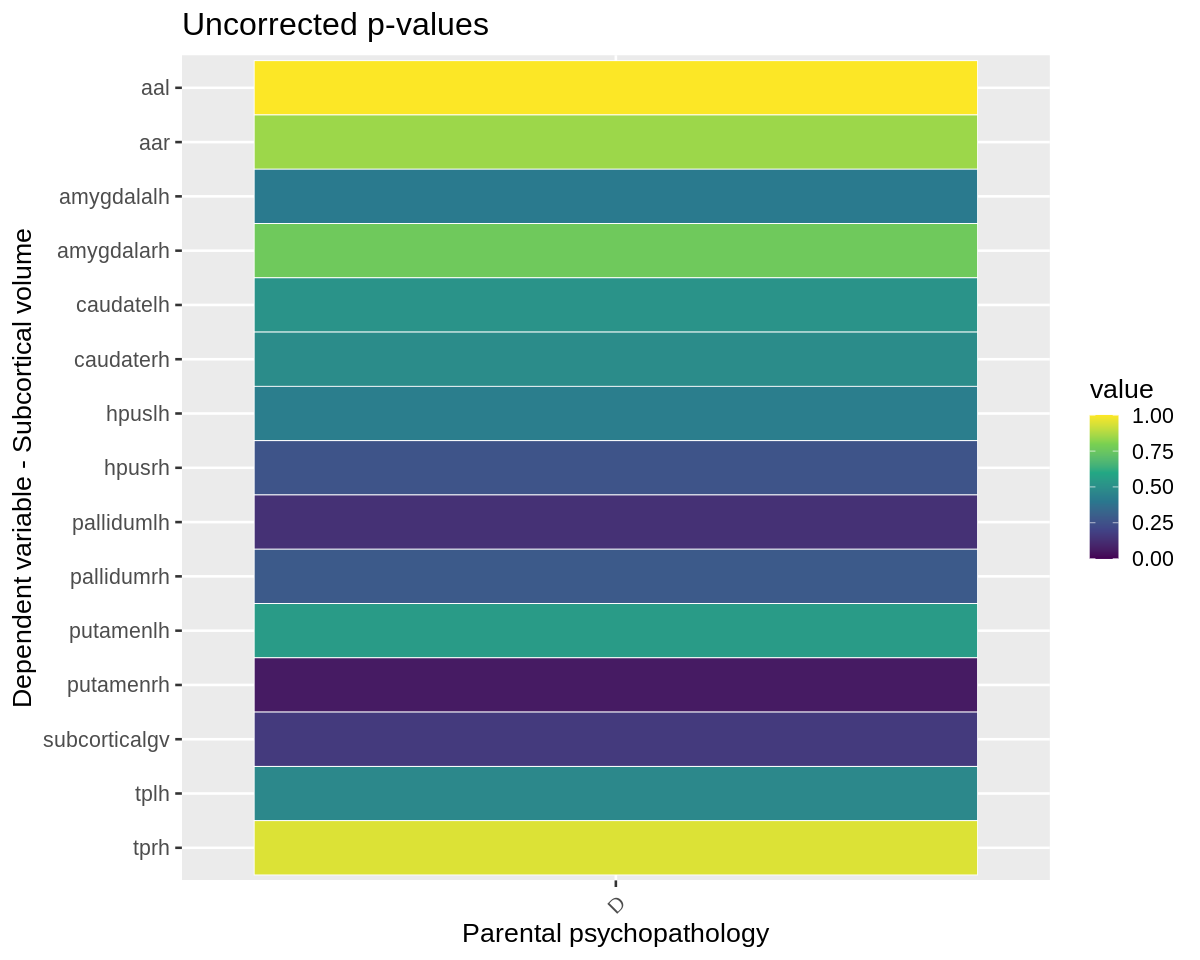

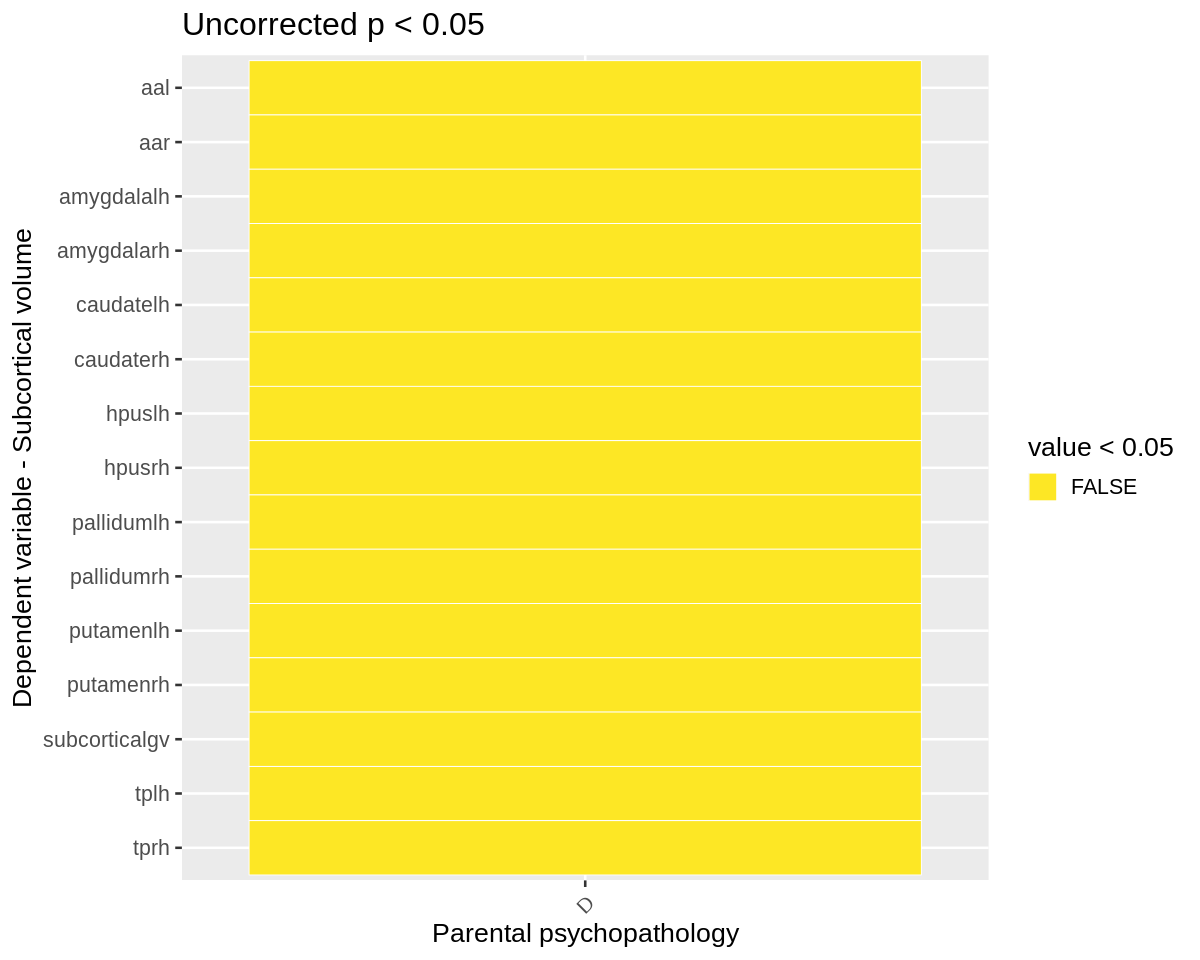

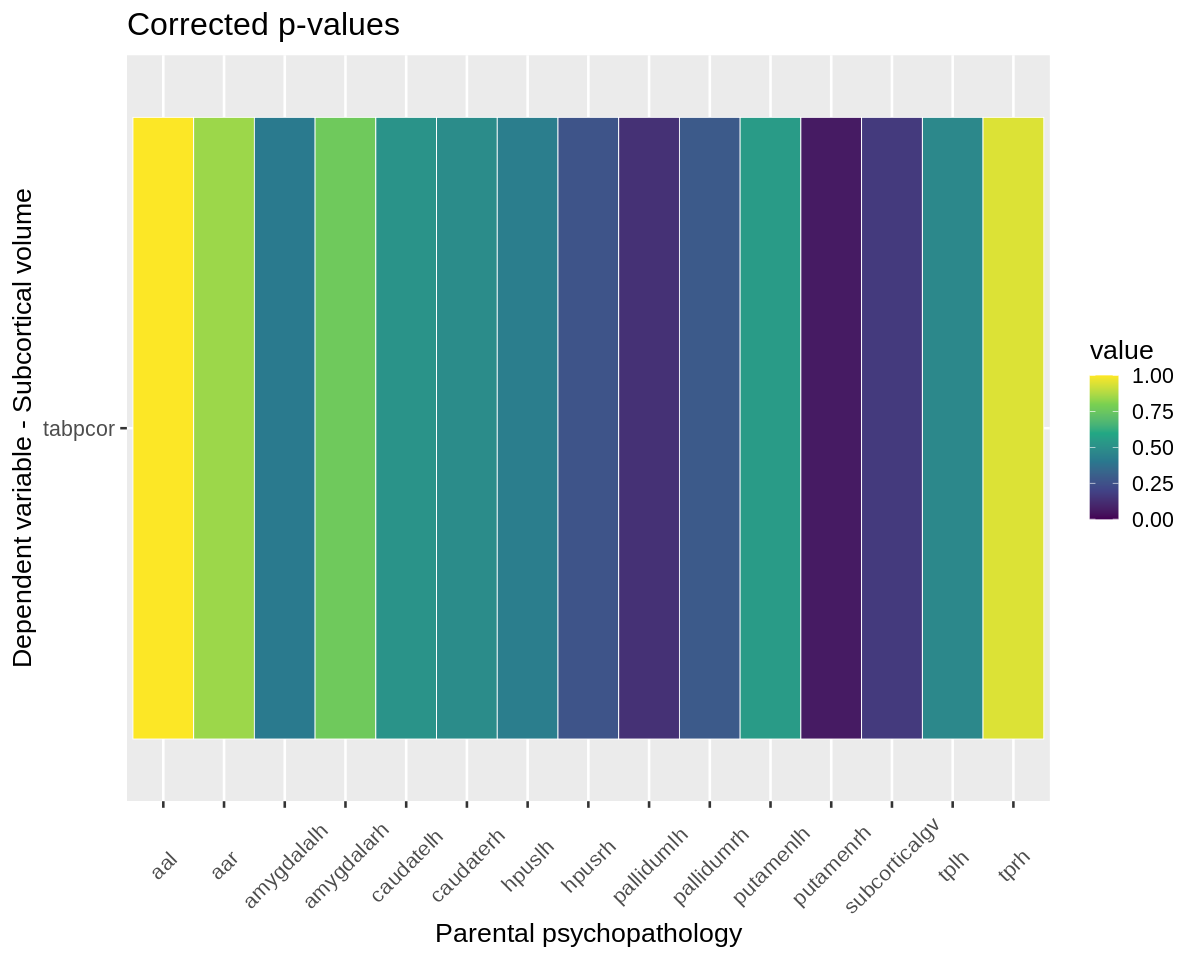

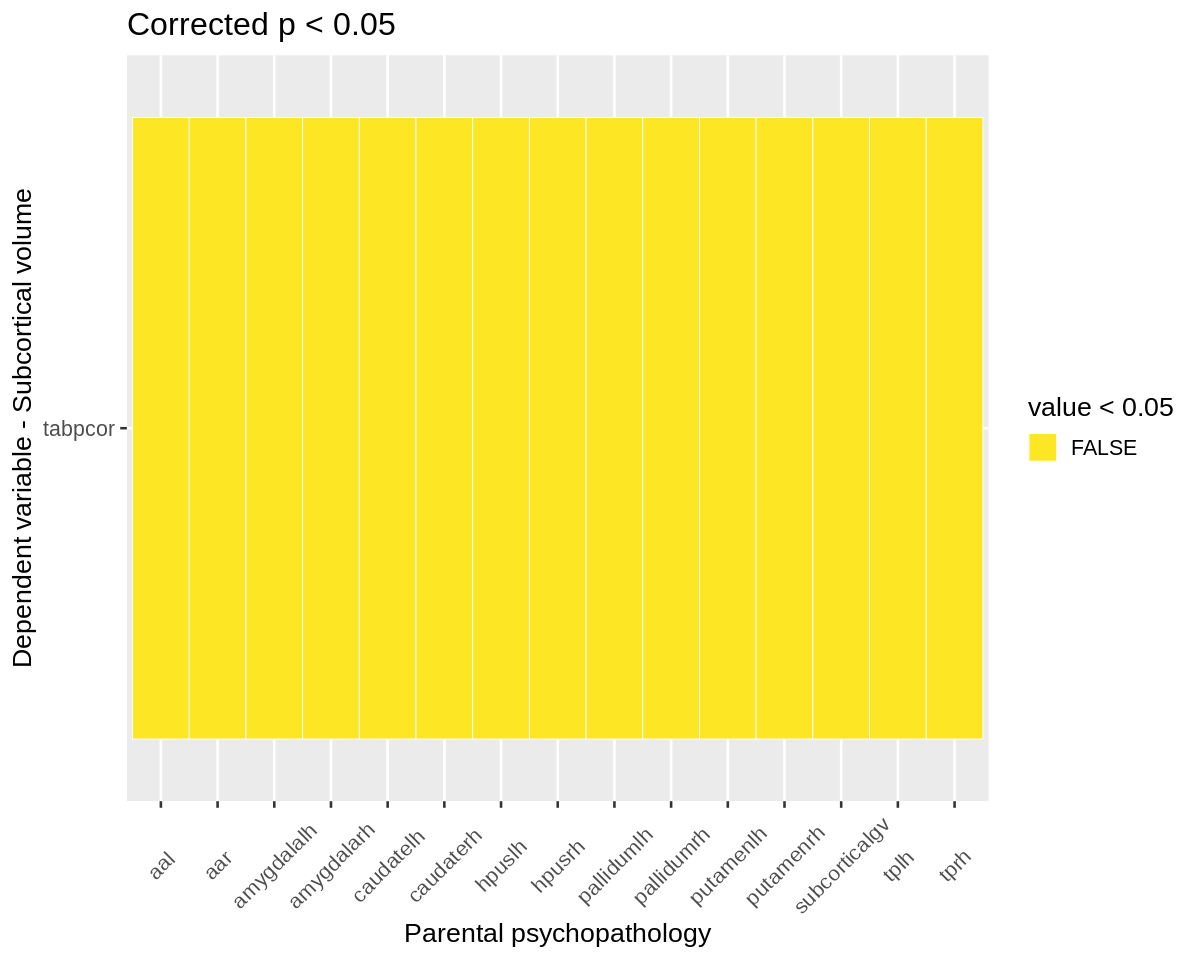

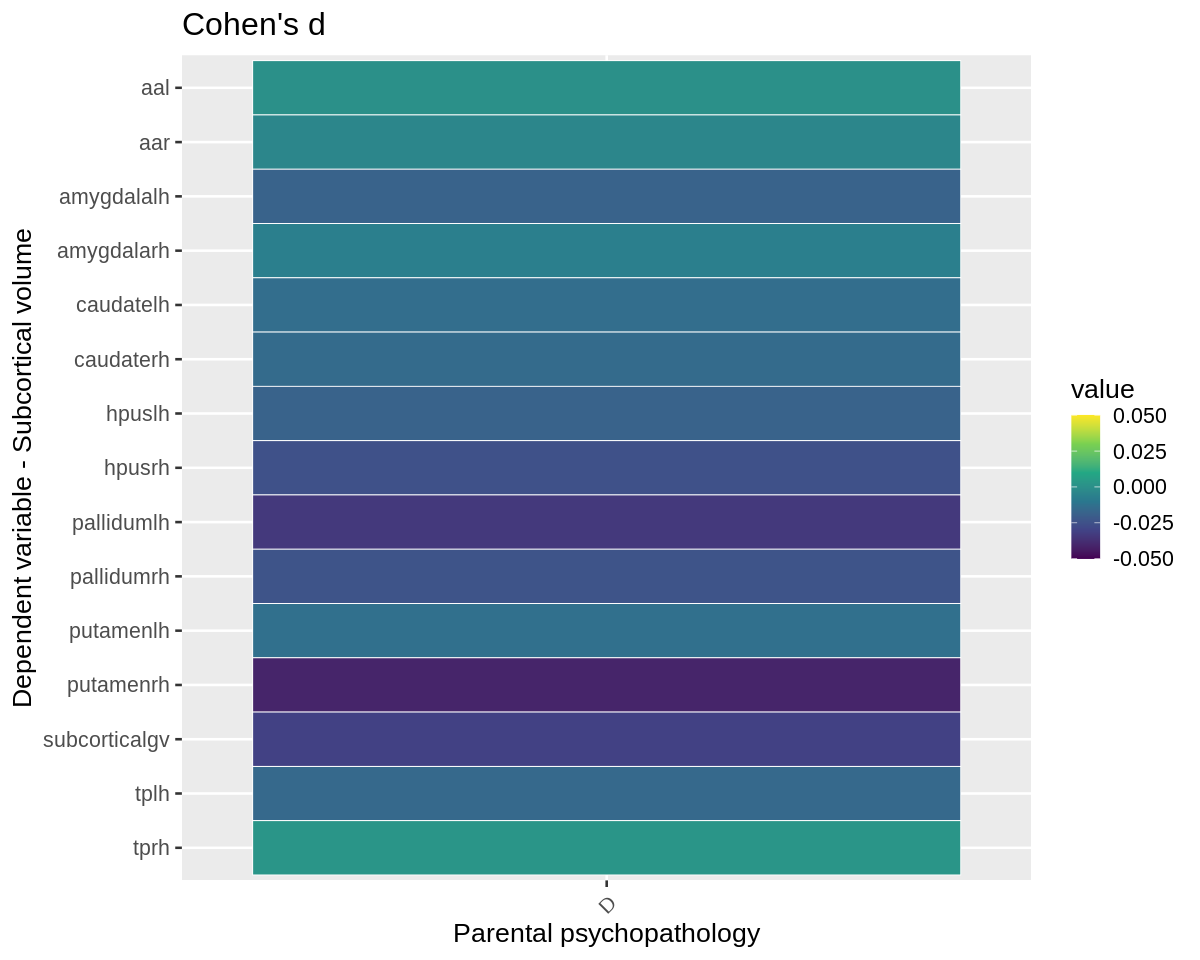

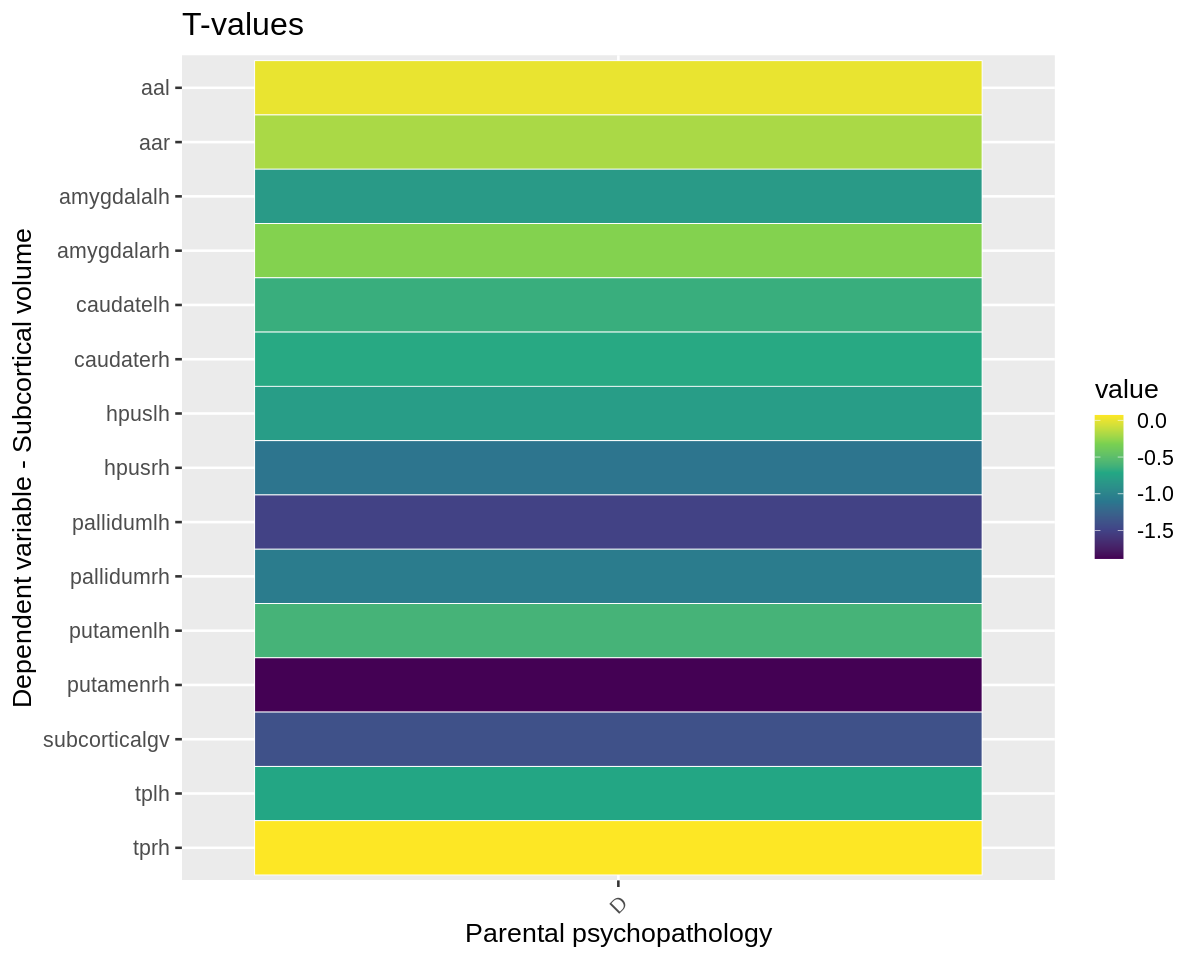

In [73]:
#Uncorrected P
options(repr.plot.width=10, repr.plot.height=8)
p1a <- ggplot(tabp_long, aes(x = rowname, y = colname, fill = value)) +
  geom_tile(colour="white",size=0.25)+
  scale_fill_viridis_c(limits = c(0,1))  +
labs(y="Dependent variable - Subcortical volume", x = "Parental psychopathology", title = "Uncorrected p-values") +
  theme_grey(base_size=16) +
  theme(plot.background=element_blank(), panel.border=element_blank(), axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5))
plot(p1a)

# logicals uncorrected p < .05
p2a <- ggplot(tabp_long, aes(x = rowname, y = colname, fill = value < .05)) +
  geom_tile(colour="white",size=0.25) +
  scale_fill_viridis_d(direction = -1)  +
labs(y="Dependent variable - Subcortical volume", x = "Parental psychopathology", title = "Uncorrected p < 0.05") +
  theme_grey(base_size=16) +
  theme(plot.background=element_blank(), panel.border=element_blank(), axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5)) 
plot(p2a)

#Corrected P
p1b <- ggplot(tabpcor_long, aes(x = rowname, y = colname, fill = value)) +
  geom_tile(colour="white",size=0.25) +
  scale_fill_viridis_c(limits = c(0,1))  +
labs(y="Dependent variable - Subcortical volume", x = "Parental psychopathology", title = "Corrected p-values") +
  theme_grey(base_size=16) +
  theme(plot.background=element_blank(), panel.border=element_blank(), axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5))
plot(p1b)

# logicals corrected p < .05 
p2b <- ggplot(tabpcor_long, aes(x = rowname, y = colname, fill = value < .05)) +
  geom_tile(colour="white",size=0.25) +
  scale_fill_viridis_d(direction = -1)  +
labs(y="Dependent variable - Subcortical volume", x = "Parental psychopathology", title = "Corrected p < 0.05") +
  theme_grey(base_size=16) +
  theme(plot.background=element_blank(), panel.border=element_blank(), axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5)) 
plot(p2b)

#Cohen's d
p3 <- ggplot(tabd_long, aes(x = rowname, y = colname, fill = value)) +
  geom_tile(colour="white",size=0.25)+
  scale_fill_viridis_c(limits = c(-0.05,0.05))  +
labs(y="Dependent variable - Subcortical volume", x = "Parental psychopathology", title = "Cohen's d")+
  theme_grey(base_size=16) +
  theme(plot.background=element_blank(), panel.border=element_blank(), axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5))
plot(p3)

#T-values
p4 <- ggplot(tabt_long, aes(x = rowname, y = colname, fill = value)) +
  geom_tile(colour="white",size=0.25)+
scale_fill_viridis_c() +
  labs(y="Dependent variable - Subcortical volume", x = "Parental psychopathology", title = "T-values")+
  theme_grey(base_size=16) +
  theme(plot.background=element_blank(), panel.border=element_blank(), axis.text.x = element_text(angle = 45, hjust = 0.5, vjust = 0.5))
plot(p4)

In [ ]:
# Further examine results of left caudate (m[[5]]), right caudate (m[[6]]), and right thalamus (m[[14]])
summ(m[[5]])

#### 5. Plot effects, random effects and examine whether assumptions are met

In [ ]:
# Settings plots
set_theme(
    base = theme_bw(),
)

# Left caudate
p1_pred <- plot_model(m[[5]], type="pred", terms = c("Depression", "Nervousness", "Mania")) #plot interaction
p1_re <- plot_model(m[[5]], type="re", terms = c("famhx_ss_momdad_dprs_p", "famhx_ss_momdad_ma_p", "famhx_ss_momdad_nrv_p")) #random effects
p1_diag <- plot_model(m[[5]], "diag") #assumptions
p1_pred
p1_re
p1_diag

In [ ]:
#right caudate
p2_pred <- plot_model(m[[6]], type="pred", terms = c("Depression", "Nervousness", "Mania")) #plot interaction
p2_re <- plot_model(m[[6]], type="re", terms = c("famhx_ss_momdad_dprs_p", "famhx_ss_momdad_ma_p", "famhx_ss_momdad_nrv_p")) #random effects
p2_diag <- plot_model(m[[7]], "diag") #assumptions
p2_pred
p2_re
p2_diag

In [ ]:
#right thalamus
p3_pred <- plot_model(m[[14]], type="pred", terms = c("Depression", "Nervousness")) #plot interaction
p3_re <- plot_model(m[[14]], type="re", terms = c("famhx_ss_momdad_dprs_p", "famhx_ss_momdad_nrv_p")) #random effects
p3_diag <- plot_model(m[[14]], "diag") #assumptions
p3_pred
p3_re
p3_diag

#### 6. Interpretation
The results of the linear mixed models that examined the effect of parental psychopathology on subcortical brain volume in 8775 children showed two three-way interactions and one two-way interaction. The three-way interactions between depression, mania, and nervousness were observed in the left (Estimate = -2.10, SE = 0.37, p = 0.03) and right caudate (Estimate = -1.99, SE = 0.98, p = 0.04). Plots revealed that children of parents that endorsed all three types of pathology showed lower bilateral caudate volume than children of parents that endorsed none, one or two pathology types. Further, a two-way interaction between depression and nervousness was observed in the right thalamus (Estimate = -0.48, SE = 0.24, p < 0.05). Children of parents with depression and nervousness comorbidity showed lower right thalamus volume than children of parents with none or one of these two types of pathology. However, none of the findings did survive the correction for multiple comparisons (Benjamini & Hochberg, 1995). Therefore, we conclude that parental psychopathology was not associated with differences in subcortical brain volume. 


Note: Violation of homoscedasticity; no constant variance of residuals. If findings survive correction for multiple comparisons, it can be solved with the NLME package by adding a weight argument. Previous attempts to use this package in a loop failed (Jupyter Notebook crashed). 

In [14]:
## Subcortical volume
# Define variables
dependentVar = colnames(df4)[grepl("^win_smri_vol_scs.*.z$", colnames(df4)) & !grepl("smri_vol_scs_intracranialv", colnames(df4))]

independentVar <- c("win_smri_vol_scs_intracranialv.z", "interview_age.z", "sex", "race_ethnicity", 
                    "puberty", "demo_prnt_ed_v2","demo_comb_income_v2", 
                    "Pathology",
                    "(1|site_id_l/rel_family_id)")


no.dependentVar = length(dependentVar)
m <- as.list(1:no.dependentVar)
d <- as.list(1:no.dependentVar)
ptab <- data.frame(matrix(NA, nrow = 42, ncol = 7))     # Adjust nrow in ptab if number of independentVar is changed
names(m) <- dependentVar
names(d) <- dependentVar
string_form <- paste0(dependentVar, "~", paste0(independentVar, collapse = " + "))

#for loop
    for (i in 1:no.dependentVar) {
        #print progress
        print(paste("Running lmer for dependent variable:", dependentVar[i], "which is", i, "out of", no.dependentVar))
        #store models in m
        m[[i]] <- lmer(string_form[i], data=df4, na.action = "na.omit")
        #cohen's d
        d[[i]] <- lme.dscore(m[[i]],data=df4,type="lme4") #Cohen's d
        ptab[[i]] <- as.data.frame(summary(m[[i]])$coefficients)
        #create dataframe (ptab)  with coefficient estimates, df, T, p-values and add sig column to indicate significance
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.1] <- "."
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.05] <- "*"
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.01] <- "**"
        ptab[[i]]$sig[ptab[[i]]$`Pr(>|t|)` < 0.001] <- "***"
        ptab[[i]]$`Pr(>|t|)` <- round(ptab[[i]]$`Pr(>|t|)`,3) #3decimals
        ptab[[i]]$d[2:42] <- d[[i]]$d
        ptab[[i]]$d[2:42] = round(ptab[[i]]$d[2:42], 3)  #3 decimals
        ptab[[i]]$d[1] <- "NA"         #intercept
}    

[1] "Running lmer for dependent variable: win_smri_vol_scs_aal.z which is 1 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_aar.z which is 2 out of 15"


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00202146 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00202146 (tol = 0.002, component 1)”


[1] "Running lmer for dependent variable: win_smri_vol_scs_amygdalalh.z which is 3 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_amygdalarh.z which is 4 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_caudatelh.z which is 5 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_caudaterh.z which is 6 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_hpuslh.z which is 7 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_hpusrh.z which is 8 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_pallidumlh.z which is 9 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_pallidumrh.z which is 10 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_putamenlh.z which is 11 out of 15"


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00402578 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00402578 (tol = 0.002, component 1)”


[1] "Running lmer for dependent variable: win_smri_vol_scs_putamenrh.z which is 12 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_tplh.z which is 13 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_tprh.z which is 14 out of 15"
[1] "Running lmer for dependent variable: win_smri_vol_scs_subcorticalgv.z which is 15 out of 15"


In [63]:
summ(m[[14]])

MODEL INFO:
Observations: 8775
Dependent Variable: win_smri_vol_scs_tprh.z
Type: Mixed effects linear regression 

MODEL FIT:
AIC = 17584.57, BIC = 17924.39
Pseudo-R² (fixed effects) = 0.57
Pseudo-R² (total) = 0.76 

FIXED EFFECTS:
-------------------------------------------------------------------------------
                                          Est.   S.E.   t val.      d.f.      p
-------------------------------------- ------- ------ -------- --------- ------
(Intercept)                               0.25   0.56     0.45   3671.83   0.65
win_smri_vol_scs_intracranialv.z          0.77   0.01    81.71   8226.57   0.00
interview_age.z                           0.02   0.01     2.86   8202.64   0.00
sexM                                      0.06   0.02     3.28   8703.56   0.00
race_ethnicity2                          -0.00   0.03    -0.12   7409.49   0.91
race_ethnicity3                           0.03   0.02     1.20   7246.01   0.23
race_ethnicity4                           0.02  

In [71]:
# Preparation for the heatmaps - visualization of the results
tabd <- data.frame(matrix(NA, nrow = 1, ncol = length(dependentVar)))  #14 is the number of pathologies (main + interactions) + 1 row for variable names
tabp <- data.frame(matrix(NA, nrow = 1, ncol = length(dependentVar)))
tabt <- data.frame(matrix(NA, nrow = 1, ncol = length(dependentVar)))

for (i in 1:no.dependentVar)
    
{
tabd[[i]] <- as.numeric(ptab[[i]]$d[42])
tabp[[i]] <- as.numeric(ptab[[i]]$'Pr(>|t|)'[42])
tabt[[i]] <- as.numeric(ptab[[i]]$'t value'[42])
}

colnames(tabd) <- sub("^win_smri_vol_scs_", "", dependentVar)
colnames(tabp) <- sub("^win_smri_vol_scs_", "", dependentVar)
colnames(tabt) <- sub("^win_smri_vol_scs_", "", dependentVar)
colnames(tabd) <- sub(".z", "", colnames(tabd))
colnames(tabp) <- sub(".z", "", colnames(tabp))
colnames(tabt) <- sub(".z", "", colnames(tabt))


row.names(tabd) <- c('D')
row.names(tabp) <- c('D')
row.names(tabt) <- c('D')


# Create table with p-values corrected for multiple comparisons using Benjamini & Hochberg (1995) ("BH") correction
tabpcor <- sapply(tabp,p.adjust,method="BH")
#rownames(tabpcor) <- c('D')

In [45]:
tabpcor

,aal,aar,amygdalalh,amygdalarh,caudatelh,caudaterh,hpuslh,hpusrh,pallidumlh,pallidumrh,putamenlh,putamenrh,tplh,tprh,subcorticalgv
D,0.136,0.560,0.5760000,0.552,0.5013333,0.696,0.584,0.4040000,0.352,0.760,0.412,0.0320000,0.300,0.924,0.0580000
A,0.692,0.688,0.2160000,0.552,0.6260000,0.696,0.752,0.6413333,0.431,0.966,0.412,0.2773333,0.300,0.943,0.4333333
M,0.692,0.560,0.2160000,0.470,0.5013333,0.696,0.264,0.6413333,0.352,0.132,0.412,0.1260000,0.184,0.024,0.0580000
N,0.288,0.372,0.3813333,0.332,0.5013333,0.696,0.964,0.9460000,0.431,0.760,0.489,0.7600000,0.300,0.943,0.9570000
